In [1]:
from collections import deque

import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
class DQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        q = self.fc(out).reshape(out.shape[0], -1)

        return q

In [3]:
def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## Main

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

SEED = 0
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
n_eval = env.spec.trials

# global values
total_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_solved = False

# load a model
target_net = DQN(obs_space, action_space).to(device)
target_net.load_state_dict(torch.load(
    './saved_models/MountainCar-v0_ep304_clear_model_dqn.pt'))

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
env.spec.max_episode_steps

200

In [6]:
env.spec.trials

100

In [7]:
env.spec.reward_threshold

-110.0

In [8]:
# env.metadata['video.frames_per_second'] = 60

In [9]:
# play
# frames = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         frames.append(env.render(mode = 'rgb_array'))
        env.render()
        action = select_action(obs, target_net)
        _obs, reward, done, _ = env.step(action)
        obs = _obs
        total_steps += 1
        ep_reward += reward     
    if done:
        env.render()
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))
#         frames.append(env.render(mode = 'rgb_array'))
#         imageio.mimsave(f'{env.spec.id}.gif', frames,)
        
        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                print(f'Mean Reward: {np.mean(reward_eval).round(decimals=2)}')
                break
env.close()

  1 Episode in   112 steps, reward -112.00
  2 Episode in   196 steps, reward -84.00
  3 Episode in   300 steps, reward -104.00
  4 Episode in   408 steps, reward -108.00
  5 Episode in   520 steps, reward -112.00
  6 Episode in   618 steps, reward -98.00
  7 Episode in   725 steps, reward -107.00
  8 Episode in   824 steps, reward -99.00
  9 Episode in   936 steps, reward -112.00
 10 Episode in  1093 steps, reward -157.00
 11 Episode in  1206 steps, reward -113.00
 12 Episode in  1290 steps, reward -84.00
 13 Episode in  1397 steps, reward -107.00
 14 Episode in  1501 steps, reward -104.00
 15 Episode in  1585 steps, reward -84.00
 16 Episode in  1681 steps, reward -96.00
 17 Episode in  1788 steps, reward -107.00
 18 Episode in  1874 steps, reward -86.00
 19 Episode in  1987 steps, reward -113.00
 20 Episode in  2072 steps, reward -85.00
 21 Episode in  2162 steps, reward -90.00
 22 Episode in  2275 steps, reward -113.00
 23 Episode in  2382 steps, reward -107.00
 24 Episode in  2478

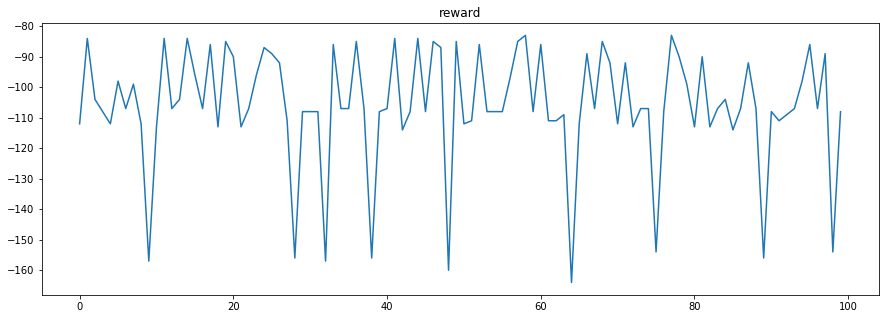

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.show()

In [11]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]